# Librairies

In [1]:
import pandas as pd
import requests
from tqdm import tqdm
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pylab as plt

# Referential

In [2]:
# We combine false and true
df = pd.concat([
    pd.DataFrame(pd.read_json('raw/registration_points_operational_true.json').data.values[0]),
    pd.DataFrame(pd.read_json('raw/registration_points_operational_false.json').data.values[0])
]).reset_index()

In [3]:
df.id.duplicated().sum()

0

In [4]:
# Create geodataframe from coordinates
df = gpd.GeoDataFrame(
    df, 
    geometry = df.location.apply(lambda x : Point(list(x['coordinates']['latLon'].values())[::-1])),
    crs = 'epsg:4326'
)

<Axes: >

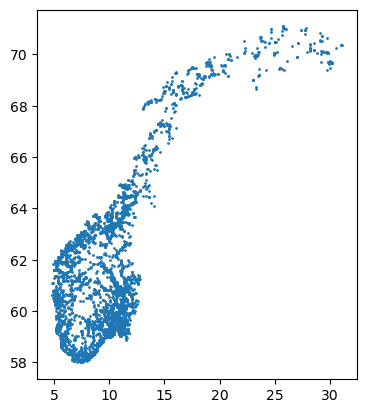

In [5]:
df.plot(markersize = 1)

In [6]:
print(df.shape)
print(2297+2716+78+1887+355+327+2+130)

(8436, 5)
7792


In [7]:
from pyproj import CRS, Transformer
from shapely.geometry import Point
from shapely.ops import transform

def geodesic_point_buffer(lat, lon, m):
    # Azimuthal equidistant projection
    aeqd_proj = CRS.from_proj4(
        f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(m).simplify(1)  # distance in metres
    # return the simplified geometry bounding polygon
    return transform(tfmr.transform, buf)

(10.546531677246096, 11.073657986821843, 59.800665262490035, 59.9771772724394)

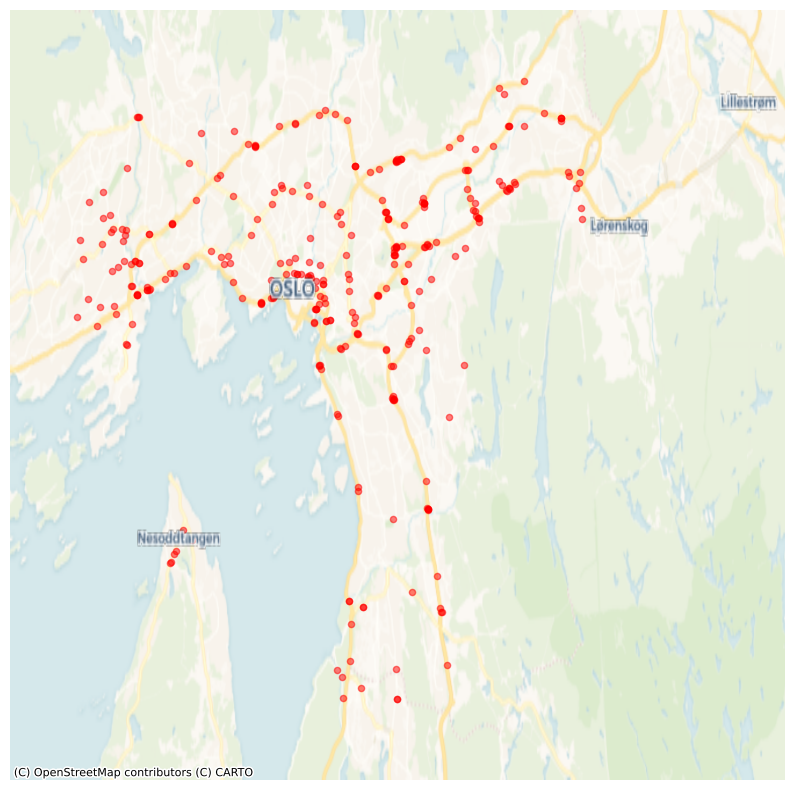

In [8]:
# Clip to Oslo 
city = 'Oslo'
city_center = (59.90614908926718,10.7686266680462) # lat, lon


import contextily as cx
mask = geodesic_point_buffer(*city_center, 10000)

# Plot sensors
ax = df.clip(mask).plot(color = 'r', markersize = 20, alpha = .5, figsize = (10,10))
# Add context in backround
cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [9]:
# This should be done with gdf prior to join
gdf = df.clip(mask)

# Map matching with OSM

In [12]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../assets").resolve()))

from map_matching_OSM import points_matching

In [13]:
gdf = points_matching(gdf)

City downloaded


 16%|█▌        | 49/310 [00:00<00:02, 127.16it/s]

Value Error - No roads found nearby current index


 24%|██▍       | 75/310 [00:00<00:01, 122.33it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


 37%|███▋      | 114/310 [00:01<00:01, 112.02it/s]

Value Error - No roads found nearby current index
Value Error - No roads found nearby current index
Value Error - No roads found nearby current index
Value Error - No roads found nearby current index


100%|██████████| 310/310 [00:02<00:00, 118.92it/s]

We failed to match 8 sensors
...on a total of 310 sensors


In [14]:
gdf[['name', 'osm_name']].dropna().drop_duplicates()[:20]

,name,osm_name
2091,Skivn Oslo gr sykkel,Skiveien
3446,Gml. Mossevei Oslo gr.,Gamle Mossevei
3848,GAMLE MOSSEVN V/BYG,Ljansbrukveien
261,Ingjerstrandvn- Oslo grense,Ingierstrandveien
1802,Mosseveien ved Fiskevollen rampe sørgående,Mosseveien
1877,Skivn. Oslo gr.,Skiveien
3846,N.PRINSDALSV V/BYGRE,Nedre Prinsdals vei
2131,Klemetsrudkrysset Hovedkjørefelt,Europaveien
4409,LIABRUDIAGONALEN,Ljabrudiagonalen
3398,Ljabrudiagonalen,Ljabrudiagonalen


# Query data

In [15]:
df.clip(mask).id.values.size

310

In [14]:
# url = 'https://trafikkdata-api.atlas.vegvesen.no/'
# list_data = []
# # Define the registration point ID
# # pointid = "73840V2041694"
# # These are the Registration point within the city area
# for pointid in tqdm(df.clip(mask).id.values) :
  
#   # Define the GraphQL query with string formatting
#   query = f"""
#   query {{
#     trafficData(trafficRegistrationPointId: "{pointid}") {{
#       volume {{
#         average {{
#           daily {{
#             byYear {{
#               year
#               total {{
#                 volume {{
#                   average
#                 }}
#               }}
#             }}
#           }}
#         }}
#       }}
#     }}
#   }}
#   """

#   # Request the values
#   response = requests.post(url=url, json={"query": query}) 
#   # Extract and format the values
#   sub = pd.DataFrame(response.json()['data']['trafficData']['volume']['average']['daily']['byYear'])
#   sub['id'] = pointid
#   list_data.append(sub)
  
# data = pd.concat(list_data)
# list_data = None
# data.dropna(inplace=True)
# data['AADT'] = data.total.apply(lambda x : x['volume']['average'])

# Save requested data
# data[['year', 'id', 'AADT']].to_csv(f'{city}/raw/trafikkdata.csv', index = False)

  0%|          | 0/310 [00:00<?, ?it/s]

100%|██████████| 310/310 [01:20<00:00,  3.87it/s]


In [17]:
data = pd.read_csv(f'{city}/raw/trafikkdata.csv')
data

,year,id,AADT
0,2019.0,05825B1909829,29
1,2020.0,05825B1909829,78
2,2021.0,05825B1909829,53
3,2022.0,05825B1909829,49
4,2023.0,05825B1909829,41
...,...,...,...
2235,2020.0,00222V444290,10706
2236,2021.0,00222V444290,10648
2237,2022.0,00222V444290,10913
2238,2023.0,00222V444290,10553


In [19]:
jf = data.set_index('id').join(
    gdf.set_index('id')[['geometry', 'name', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osmid',]], how = 'inner'
)

In [20]:
jf.rename(columns = {'name':'raw_name'}, inplace=True)

In [22]:
jf.year.value_counts().sort_index()

year
1986.0      3
1987.0      2
1988.0      3
1989.0     10
1990.0      8
1991.0     10
1992.0     11
1993.0     19
1994.0     40
1995.0     40
1996.0     35
1997.0     44
1998.0     27
1999.0     35
2000.0     27
2001.0     32
2002.0     39
2003.0     45
2004.0     48
2005.0     58
2006.0     58
2007.0     63
2008.0     62
2009.0     60
2010.0     56
2011.0     44
2012.0     34
2013.0     26
2014.0     20
2015.0     36
2016.0     72
2017.0     88
2018.0    101
2019.0    141
2020.0    161
2021.0    169
2022.0    167
2023.0    172
2024.0    174
Name: count, dtype: int64

In [23]:
jf = gpd.GeoDataFrame(jf, geometry = 'geometry', crs = 'epsg:4326')

# Final saving

In [24]:
for year in range(2015, 2025) :
    jf[jf.year == year][[
        'AADT', 'geometry', 'raw_name', 'osm_name', 'osm_type', 'osm_lanes',  'osm_oneway', 'osm_distance', 'osmid', 
        ]].to_file(
        f'{city}/treated/{city}_AADT_{year}.geojson', index = False
    )